In [1]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob

from keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [2]:
def filename_to_target(x):
    if 'target_human' in x:
        return 'target_human'
    elif 'human' in x:
        return 'human'
    elif 'target_gun' in x:
        return 'target_gun'
    elif 'target_laser' in x:
        return 'target_laser'
    elif 'target_tank' in x:
        return 'target_tank'

In [3]:
targets_compared = {
    'human': 0,
    'target_human': 1,
    'target_laser': 2,
    'target_gun': 3, 
    'target_tank': 4
}

In [4]:
train = pd.DataFrame()
train['filename'] = os.listdir('dataset/train/')
train['path'] = train.filename.apply(lambda x: 'dataset/train/'+x)
train['target_name'] = train.filename.apply(lambda x: filename_to_target(x))
train = train[train.target_name.notnull()].reset_index(drop=True)
train['target'] = train.target_name.apply(lambda x: targets_compared[x])

In [5]:
test = pd.read_csv('enc_targets.csv', header=None)
test.columns = ['target', 'filename']
test['path'] = test.filename.apply(lambda x: 'dataset/test/'+x)

In [6]:
train

,filename,path,target_name,target
0,target_gun_IMG_170241101x1551.jpg,dataset/train/target_gun_IMG_170241101x1551.jpg,target_gun,3
1,target_human_IMG_4249832x1805.jpg,dataset/train/target_human_IMG_4249832x1805.jpg,target_human,1
2,target_human_IMG_37903753x539.jpg,dataset/train/target_human_IMG_37903753x539.jpg,target_human,1
3,target_gun_IMG_208091009x943.jpg,dataset/train/target_gun_IMG_208091009x943.jpg,target_gun,3
4,target_human_IMG_41211897x572.jpg,dataset/train/target_human_IMG_41211897x572.jpg,target_human,1
...,...,...,...,...
18520,target_gun_IMG_178061005x378.jpg,dataset/train/target_gun_IMG_178061005x378.jpg,target_gun,3
18521,human_IMG_38875668x938.jpg,dataset/train/human_IMG_38875668x938.jpg,human,0
18522,target_laser_camera4_6711_16014661937500970001...,dataset/train/target_laser_camera4_6711_160146...,target_laser,2
18523,target_tank_IMG_163741090x820.jpg,dataset/train/target_tank_IMG_163741090x820.jpg,target_tank,4


In [7]:
def augment_image(image):

    aug = A.Compose([
        
#         A.OneOf([
#             A.RandomSizedCrop(min_max_height=(150, 150), height=200, width=200, p=0.5),
#             A.PadIfNeeded(min_height=200, min_width=200, p=0.5)
#         ], p=0.5),
        
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=[0, 15], p=0.5),
        
#         A.OneOf([
#             A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#             A.GridDistortion(p=0.5),
#             A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1),
#         ], p=0.5),
        
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),
        ], p=0.5),
        
        A.Cutout(num_holes=5, max_h_size=20, max_w_size=20, fill_value=0, always_apply=False, p=0.5)
    
    ])

    augmented = aug(image=image)

    return augmented['image'] 

In [8]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=8,
                 input_shape=(224, 224, 3),
                 shuffle=True):
        
        self.paths = df.path.values
        self.labels = df.target.values
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths, labels):
    
        X_batch = []
        y_batch = []
        
        for path, label in zip(paths, labels):
            
            X = cv2.imread(path).copy()
            X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
            X = cv2.resize(X, (self.input_shape[0], self.input_shape[1]))
            if self.augment:
                X = augment_image(X)
            X_batch.append(X / 255.)
            
            y = np.zeros((5))
            y[label] = 1
            y_batch.append(y)
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes],
                                [self.labels[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

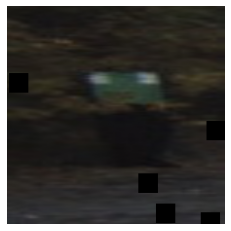

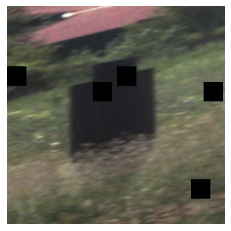

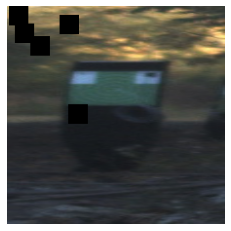

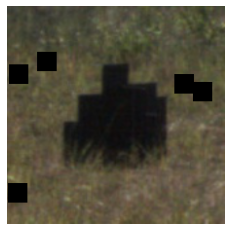

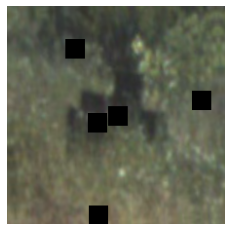

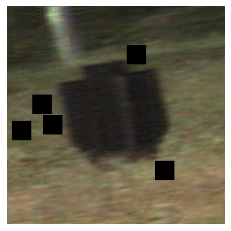

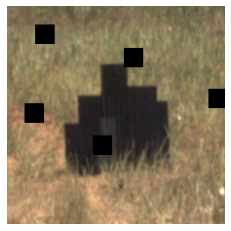

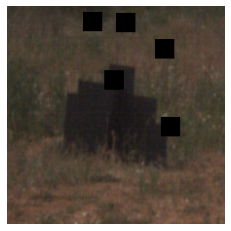

In [123]:
traingen = CustomDataGen(train)

for x, y in traingen:
    break

i = 0
for xx, yy in zip(x, y):
    plt.imshow(xx)
#     plt.suptitle(yy)
    plt.axis('off')
    plt.savefig('{}.png'.format(i))
    plt.show()
    i+=1

## Training

In [51]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [52]:
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

27025408/27018416 [==============================] - 16s 1us/step


In [55]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 6,904,460
Trainable params: 6,842,405
Non-trainable params: 62,055
______________________________________________

In [72]:
train_df, val_df = train_test_split(train, test_size=0.2, stratify=train['target'])

train_indxs = []
k = 0
for _, train_index in StratifiedKFold(n_splits=4).split(train_df, train_df.target):
    train_index = list(train_index)
    if k > 0:
        train_index += train_indxs[k-1]
    train_indxs.append(train_index)
    k += 1

### First traingen

In [64]:
traingen_1 = CustomDataGen(train_df.iloc[train_indxs[0]], input_shape=(224, 224, 3), batch_size=8)
valgen = CustomDataGen(val_df, input_shape=(224, 224, 3), batch_size=8, augment=False)

In [66]:
train_df.iloc[train_indxs[0]].groupby('target').path.count()

target
0    1662
1    5452
2    1576
3    2070
4    1096
Name: path, dtype: int64

In [67]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [63]:
results = model.fit(traingen_1, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/30
 37/370 [==>...........................] - ETA: 2:29 - loss: 0.1626 - accuracy: 0.9392 - auc: 0.9949

KeyboardInterrupt: 

### Second traingen

In [ ]:
traingen_2 = CustomDataGen(train_df.iloc[train_indxs[1]], input_shape=(224, 224, 3), batch_size=8)
valgen = CustomDataGen(val_df, input_shape=(224, 224, 3), batch_size=8, augment=False)

In [ ]:
K.clear_session()

model = load_model('models/EfficientNetB1/model_224.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [254]:
checkpoint_path = 'models/EfficientNetB1/model_224_2.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [255]:
results = model.fit(traingen_2, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
787/787 [==============================] - 274s 344ms/step - loss: 0.1221 - accuracy: 0.9617 - auc: 0.9967 - val_loss: 181.0448 - val_accuracy: 0.4597 - val_auc: 0.6648

Epoch 00001: val_loss improved from inf to 181.04485, saving model to models/EfficientNetB0/model_224_2.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
787/787 [==============================] - 269s 342ms/step - loss: 0.1036 - accuracy: 0.9665 - auc: 0.9974 - val_loss: 1.9034 - val_accuracy: 0.4139 - val_auc: 0.6887

Epoch 00002: val_loss improved from 181.04485 to 1.90340, saving model to models/EfficientNetB0/model_224_2.h5
Epoch 3/50
787/787 [==============================] - 271s 344ms/step - loss: 0.1016 - accuracy: 0.9686 - auc: 0.9976 - val_loss: 2.3874 - val_accuracy: 0.2360 - val_auc: 0.5340

Epoch 00003: val_loss did not improve from 1.90340
Epoch 4/50
787/787 [==============================] - 270s 342ms/step - loss: 0.1003 - accuracy: 0.9695 - auc: 0.9973 - val_loss: 2.8035 - val_accuracy: 0.3426 - val_auc: 0.6333

Epoch 00004: val_loss did not improve from 1.90340
Epoch 5/50
787/787 [==============================] - 271s 344ms/step - loss: 0.0808 - accuracy: 0.9743 - auc: 0.9982 - val_loss: 5.3364 - val_accuracy: 0.1358 - val_auc: 0.5052

Epoch 00005: val_loss did not improve from 1.90340
Epoch 6/50
787/787 [

KeyboardInterrupt: 

### Third traingen

In [68]:
traingen_3 = CustomDataGen(train_df.iloc[train_indxs[2]], input_shape=(224, 224, 3), batch_size=8)
valgen = CustomDataGen(val_df, input_shape=(224, 224, 3), batch_size=8, augment=False)

In [69]:
K.clear_session()

model = load_model('models/EfficientNetB1/model_224.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=metrics)

In [70]:
checkpoint_path = 'models/EfficientNetB1/model_224_3.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [71]:
results = model.fit(traingen_3, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
 656/1111 [================>.............] - ETA: 3:26 - loss: 0.3142 - accuracy: 0.8950 - auc: 0.9853

KeyboardInterrupt: 

### Fourth traingen

In [73]:
traingen_4 = CustomDataGen(train_df.iloc[train_indxs[3]], input_shape=(224, 224, 3), batch_size=8)
valgen = CustomDataGen(val_df, input_shape=(224, 224, 3), batch_size=8, augment=False)

In [77]:
K.clear_session()

model = load_model('models/EfficientNetB0/model_224_3.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=metrics)

In [78]:
checkpoint_path = 'models/EfficientNetB0/model_224_4.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [79]:
results = model.fit(traingen_4, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
1852/1852 [==============================] - 633s 340ms/step - loss: 0.0193 - accuracy: 0.9949 - auc: 0.9994 - val_loss: 0.0331 - val_accuracy: 0.9933 - val_auc: 0.9987

Epoch 00001: val_loss improved from inf to 0.03308, saving model to models/EfficientNetB0/model_224_4.h5
Epoch 2/50
1852/1852 [==============================] - 661s 357ms/step - loss: 0.0181 - accuracy: 0.9948 - auc: 0.9997 - val_loss: 0.0267 - val_accuracy: 0.9954 - val_auc: 0.9990

Epoch 00002: val_loss improved from 0.03308 to 0.02674, saving model to models/EfficientNetB0/model_224_4.h5
Epoch 3/50
1852/1852 [==============================] - 630s 340ms/step - loss: 0.0164 - accuracy: 0.9950 - auc: 0.9997 - val_loss: 0.0318 - val_accuracy: 0.9935 - val_auc: 0.9990

Epoch 00003: val_loss did not improve from 0.02674
Epoch 4/50
1852/1852 [==============================] - 618s 334ms/step - loss: 0.0147 - accuracy: 0.9951 - auc: 0.9997 - val_loss: 0.0283 - val_accuracy: 0.9946 - val_auc: 0.9988

Epoch 00004

### Fifth training

In [94]:
train_df, val_df = train_test_split(train, test_size=0.2, stratify=train['target'])

In [95]:
traingen_5 = CustomDataGen(train_df, input_shape=(224, 224, 3), batch_size=8)
valgen = CustomDataGen(val_df, input_shape=(224, 224, 3), batch_size=8, augment=False)

In [96]:
K.clear_session()

model = load_model('models/EfficientNetB0/model_224_4.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=metrics)

In [97]:
checkpoint_path = 'models/EfficientNetB0/model_224_5.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [99]:
results = model.fit(traingen_5, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
1852/1852 [==============================] - 658s 355ms/step - loss: 0.0175 - accuracy: 0.9951 - auc: 0.9997 - val_loss: 0.0110 - val_accuracy: 0.9970 - val_auc: 0.9998

Epoch 00001: val_loss improved from inf to 0.01103, saving model to models/EfficientNetB0/model_224_5.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1852/1852 [==============================] - 639s 345ms/step - loss: 0.0146 - accuracy: 0.9953 - auc: 0.9998 - val_loss: 0.0101 - val_accuracy: 0.9970 - val_auc: 0.9998

Epoch 00002: val_loss improved from 0.01103 to 0.01013, saving model to models/EfficientNetB0/model_224_5.h5
Epoch 3/50
1852/1852 [==============================] - 650s 351ms/step - loss: 0.0140 - accuracy: 0.9961 - auc: 0.9997 - val_loss: 0.0326 - val_accuracy: 0.9881 - val_auc: 0.9996

Epoch 00003: val_loss did not improve from 0.01013
Epoch 4/50
  11/1852 [..............................] - ETA: 9:47 - loss: 0.0063 - accuracy: 1.0000 - auc: 1.0000

KeyboardInterrupt: 

# Testing

In [80]:
def compute_accuracy(gt, pr):
    
    targets_ammount = [0 for i in range(5)]
    correct_preds = [0 for i in range(5)]
    
    for gt_value, pr_value in zip(gt, pr):
        targets_ammount[gt_value] +=1
        if pr_value == gt_value:
            correct_preds[gt_value] +=1
    
    avg_acc = sum(correct_preds)/sum(targets_ammount)
    
    per_target_acc = [correct_preds[i] / targets_ammount[i] for i in range(5) if targets_ammount[i] ]
    
    weights = [0.4, 0.3, 0.09, 0.12, 0.06]
    absolute_score = sum([per_target_acc[i]/weights[i] for i in range(5)])

    print('avg_acc {}, \n\nper_class_acc \nhuman:{} \ntarget_human:{} \ntarget_laser:{} \ntarget_gun:{} \ntarget_tank:{}'.format(avg_acc,*per_target_acc))
    print('\n\nscore {}'.format(absolute_score))
    
    return avg_acc, per_target_acc

In [83]:
public_test = pd.DataFrame()

dirs = ['human/', 'target_1human/', 'target_2laser/', 'target_3gun/', 'target_4tank/']

for i, d in enumerate(dirs):
    
    temp_filenames = ['/'.join(f.split('/')[2:]) for f in glob('public_test/{}/*.jpg'.format(d))]
    temp_paths = ['public_test/'+d+x for x in temp_filenames]
    temp_targets = [i for x in temp_filenames]
    
    temp_df = pd.DataFrame()
    temp_df['filename'] = temp_filenames
    temp_df['path'] = temp_paths
    temp_df['target'] = temp_targets
    
    public_test = pd.concat([public_test, temp_df], ignore_index=True)

In [138]:
private_test = pd.DataFrame()
private_filenames = ['/'.join(f.split('/')[1:]) for f in glob('private_test/*.jpg'.format(d))]
private_paths = ['private_test/'+x for x in private_filenames]
private_test['filename'] = private_filenames
private_test['path'] = private_paths

In [283]:
# model = load_model('models/EfficientNetB0/model_224_3.h5')

# preds = []

# for path in tqdm(public_test.path):
    
#     X_batch = []

#     X = cv2.imread(path).copy()
#     X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
#     X = cv2.resize(X, (224, 224))
#     X_batch.append(X / 255.)
    
#     for i in range(31):
#         X_batch.append(augment_image(X) / 255.)
        
#     X_batch = np.array(X_batch)
    
#     pred_batch = model.predict(X_batch)
#     pred = np.mean(pred_batch, axis=0)
    
#     preds.append(np.where(pred == pred.max())[0][0])

100%|██████████| 1942/1942 [10:01<00:00,  3.23it/s]


In [139]:
model = load_model('models/EfficientNetB0/model_224_5.h5')

preds = []

for path in tqdm(private_test.path):

    X = cv2.imread(path).copy()
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    X = cv2.resize(X, (224, 224)) / 255.
    
    pred = model.predict(X[np.newaxis, ...])
    preds.append(np.where(pred == pred.max())[1][0])

100%|██████████| 4738/4738 [02:58<00:00, 26.58it/s]


In [141]:
private_test['prediction'] = preds

In [143]:
private_test[['prediction', 'filename']]

,prediction,filename
0,4,camera_2_44622980.jpg
1,0,camera_2_3272501.jpg
2,3,camera_2_3434069.jpg
3,3,camera_2_37133449.jpg
4,1,camera_2_30791200.jpg
...,...,...
4733,0,camera_2_2585790.jpg
4734,3,camera_2_48153022.jpg
4735,4,camera_2_14984613.jpg
4736,1,camera_2_42552190.jpg


In [144]:
private_test[['prediction', 'filename']].to_csv('Kotyatki.csv', index=False)

In [146]:
# test['pred'] = preds
_ = compute_accuracy(test['target'], test['pred'])

avg_acc 0.9966230476994512, 

per_class_acc 
human:0.9985185185185185 
target_human:0.9971537001897534 
target_laser:0.996694214876033 
target_gun:0.9965156794425087 
target_tank:0.9918200408997955


score 41.729153472568896


In [103]:
# public_test['pred'] = preds

In [147]:
_ = compute_accuracy(public_test['target'], public_test['pred'])

avg_acc 0.995880535530381, 

per_class_acc 
human:0.995 
target_human:0.9966666666666667 
target_laser:1.0 
target_gun:0.9958677685950413 
target_tank:0.9916666666666667


score 41.74750918273646


In [277]:
# public_test[['pred', 'filename']].to_csv('submission.csv', index=False)

In [ ]:
# avg_acc 0.9809474768280123

# per_class_acc 
# human:0.9775 
# target_human:0.995 
# target_laser:0.9777777777777777 
# target_gun:0.9545454545454546 
# target_tank:0.9916666666666667
    
# score 41.1069374298541

In [ ]:
# avg_acc 0.9891864057672503, 

# per_class_acc 
# human:0.98 
# target_human:1.0 
# target_laser:0.9888888888888889 
# target_gun:0.987603305785124 
# target_tank:1.0


# score 41.667681869197025

In [ ]:
# avg_acc 0.9933058702368692, 

# per_class_acc 
# human:0.9875 
# target_human:1.0 
# target_laser:0.9944444444444445 
# target_gun:0.9958677685950413 
# target_tank:0.9916666666666667


# score 41.67814189878584

In [ ]:
# avg_acc 0.9948506694129763

# per_class_acc 
# human:0.99125 
# target_human:1.0 
# target_laser:0.9944444444444445 
# target_gun:0.9958677685950413 
# target_tank:0.9916666666666667


# score 41.687516898785844

In [ ]:
# avg_acc 0.995880535530381, 

# per_class_acc 
# human:0.995 
# target_human:0.9966666666666667 
# target_laser:1.0 
# target_gun:0.9958677685950413 
# target_tank:0.9916666666666667


# score 41.74750918273646

In [ ]:
# avg_acc 0.9809474768280123
# avg_acc 0.9891864057672503
# avg_acc 0.9933058702368692
# avg_acc 0.9948506694129763

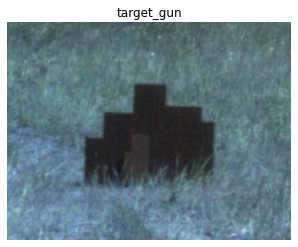

In [122]:
tar = 'target_gun'
plt.imshow(cv2.imread(train[train.target_name == tar].path.iloc[11]))
plt.title(tar)
plt.axis('off')
plt.savefig('{}.png'.format(tar))
plt.show()

In [121]:
train.target_name.unique()

array(['target_gun', 'target_human', 'target_tank', 'human',
       'target_laser'], dtype=object)

In [124]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 4,378,792
Trainable params: 4,336,769
Non-trainable params: 42,023
______________________________________________

In [126]:
!unzip private_test.zip

Archive:  ./private_test.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./private_test.zip or
        ./private_test.zip.zip, and cannot find ./private_test.zip.ZIP, period.
